# Check the influence of the time stepping in the bidirectionally coupled solver 

- runs: 001, 002, 003, 004
- time stepping: 2e-8s, 2e-10s, 2e-11s, 2e-12s
- particle positions are recorded for every 1e-8s
- output folder from COMSOL is /Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data/temporal_resolution/time_outputs
- COMSOL mph files are /Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/02.MR.102.temporal_refinement.save_1e8.001_out.mph and so on

## Check the qrmax function from COMSOL for the three runs

- is computed by COMSOL as maximum(sqrt(qy^2+qz^2))

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
%matplotlib inline

In [92]:
# thesis folder
savefolder = '/Users/hkromer/polybox/Thesis/Chapters/DetailedNeutronGeneratorCharacterization/Figures/'
figname = 'COMSOL_temporal_refinement'
figname = f'{savefolder}/{figname}/{figname}.pdf'

figname2 = 'COMSOL_temporal_refinement_x_avg'
figname2 = f'{savefolder}/{figname2}/{figname2}.pdf'

In [93]:
import matplotlib
from matplotlib.ticker import AutoMinorLocator
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('font', weight='bold')
matplotlib.rcParams['font.weight']= 'bold'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
plt.rcParams["axes.labelweight"] = "heavy"
plt.rc('text', usetex=True)

,time,qrmax,x_avg,run
0,0.000000e+00,0.592559,-1.400000,001
1,1.000000e-08,0.551885,-1.108813,001
2,2.000000e-08,0.317938,0.022867,001
3,3.000000e-08,0.131354,3.381264,001
4,4.000000e-08,0.594897,9.165752,001
...,...,...,...,...
21,2.100000e-07,2.217020,70.013134,004
22,2.200000e-07,2.217020,70.013134,004
23,2.300000e-07,2.217020,70.013134,004
24,2.400000e-07,2.217020,70.013134,004


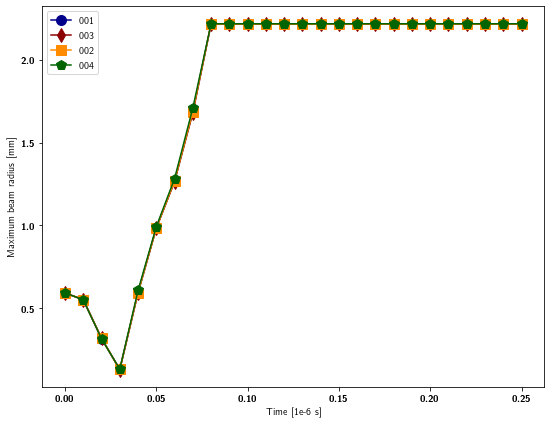

In [94]:
path ='/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data/temporal_resolution/time_outputs'
files = [f for f in os.listdir(path) if 'qrmax' in f]
data = pd.DataFrame()

plt.figure(figsize=(9,7))
colors = ['darkblue', 'darkred', 'darkorange', 'darkgreen']
markers = ['o','d','s','p']
for file,c,m in zip(files, colors,markers):
    # get the run id
    run = re.findall(r'qrmax\.(\d*)\.', file)[0]
    data_t = pd.read_csv(f'{path}/{file}', skiprows=4)
    data_t.columns = ['time', 'qrmax', 'x_avg'] # time in seconds, beam radius in mm
    data_t['run'] = run
    data = data.append(data_t)
    
    # plot
    data_t['time'] = data_t['time'] * 1e6 # convert to mus
    plt.plot(data_t['time'].values, data_t['qrmax'].values, color=c, label=run, marker=m, markersize=10)
    plt.xlabel('Time [1e-6 s]')
    plt.ylabel('Maximum beam radius [mm]')
    plt.legend()

data

In [95]:
len(data['x_avg'].unique()), len(data['time'].unique()) 

(33, 26)

This is not very insightful, how does the difference change over the different time steppings?

In [96]:
# group by time step and compute difference
def compute_difference(df):
    assert len(df) == 4

    ref = df[df['run']=='004'].loc[:,'qrmax'].values[0] # reference qr for run 004    

    
    s_diff = np.abs(df['qrmax'] - ref)
    s_rel_diff_qrmax = np.abs(df['qrmax'] - ref)/(ref)
    
    out_df = pd.DataFrame()

    out_df['rel_diff_qrmax']=s_rel_diff_qrmax
    out_df['diff_qrmax']=s_diff
    out_df['run']=df['run']
    


#     df = df.reset_index()


    return out_df

    
# make sure the time steps have the same accuracy
data['time'] = np.round(data['time'],9) 
data_agg = data.groupby('time').apply(lambda x: compute_difference(x)).reset_index()
# data_agg
d_ts = {'001': 8, 
        '002': 9, 
        '003': 10, 
        '004': 11}

data_agg['ts'] = data_agg['run'].map(d_ts)
data_agg = data_agg.reset_index(drop=True)
ref_data = data[data['run']=='004']
s = ref_data.set_index('time')['x_avg']
data_agg['x_avg'] = data_agg['time'].map(s)
data_agg

,time,level_1,rel_diff_qrmax,diff_qrmax,run,ts,x_avg
0,0.000000e+00,0,0.001436,0.000852,001,8,-1.400000
1,0.000000e+00,0,0.001436,0.000852,003,10,-1.400000
2,0.000000e+00,0,0.001436,0.000852,002,9,-1.400000
3,0.000000e+00,0,0.000000,0.000000,004,11,-1.400000
4,1.000000e-08,1,0.000790,0.000436,001,8,-1.111078
...,...,...,...,...,...,...,...
99,2.400000e-07,24,0.000000,0.000000,004,11,70.013134
100,2.500000e-07,25,0.000716,0.001588,001,8,70.013134
101,2.500000e-07,25,0.000174,0.000387,003,10,70.013134
102,2.500000e-07,25,0.000822,0.001822,002,9,70.013134


/Users/hkromer/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


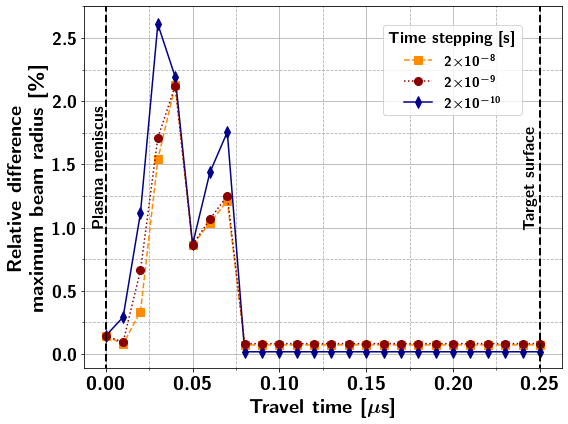

In [104]:
# plot for each time
fig, ax1 = plt.subplots(figsize=(8, 6))
runs = data_agg['run'].unique()
fs = 20
markersize = 8
colors = ['darkorange', 'darkblue', 'darkred']
markers = ['s', 'd', 'o']
linestyles = ['--', '-' , "dotted", (0, (3, 5, 1, 5))]

for run,c,m,linest in zip(runs, colors,markers,linestyles):
    if run != '004':
        data_plot = data_agg[data_agg['run'] == run]
        data_plot['time'] = data_plot['time'] * 1e6 # convert to mus
        
        ts = data_plot['ts'].unique()[0]
        Y = 100.0 * data_plot['rel_diff_qrmax'].values
        ts = '-' + str(ts)
        ax1.plot(data_plot['time'].values, Y, color=c, linestyle=linest, label=r'\textbf{{$2\times$10$^{{{}}}$}}'.format(ts), marker=m, markersize=markersize)

ylims = ax1.get_ylim()


ax1.plot((0.0, 0.0), (-10, 10), 'k--', linewidth=2, color='black')  # Plasma meniscus
ax1.plot((0.25, 0.25), (-10, 10), 'k--', linewidth=2, color='black')  # Target surface
ax1.set_xlabel(r"\textbf{Travel time [$\mu$s]}", fontsize=fs)
ax1.set_ylabel(r"\textbf{Relative difference" + "\n"+  r"\textbf{maximum beam radius [\%]}", fontsize=fs)
ax1.tick_params('x', colors='black', labelsize=fs)
ax1.tick_params(axis='y', labelsize=fs-2)
ax1.set_ylim(ylims[0],2.75)
ax1.text(-0.008, 1.02, s=r'\textbf{Plasma meniscus}', color='black',  fontsize=fs-4, rotation=90) # PLASMA
ax1.text(0.24, 1., s=r'\textbf{Target surface}', color='black',  fontsize=fs-4, rotation=90) # target


# ax1.set_yticks(np.arange(2.0,3.1,0.2))
# minor ticks x
minor_locator = AutoMinorLocator(2)
ax1.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)

hs, ls = ax1.get_legend_handles_labels()

leg1 = plt.legend([hs[0],hs[2],hs[1]],[ls[0],ls[2],ls[1]], loc=(0.625,0.70), fontsize=fs-6)
leg1.set_title(r"\textbf{Time stepping [s]}", prop = {'size': fs-4})
ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')


plt.tight_layout()
plt.savefig(figname)
plt.show()


### Plot with the x_avg on the x axis


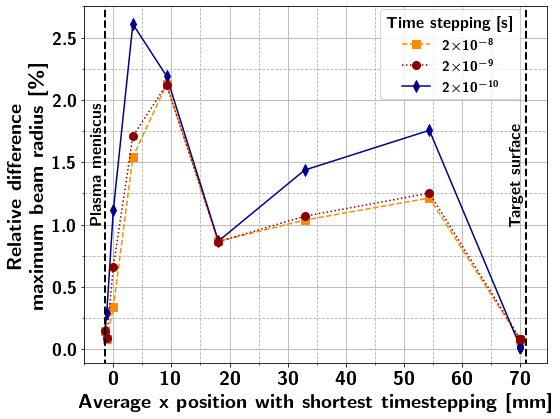

In [101]:
# plot for each time
fig, ax1 = plt.subplots(figsize=(8, 6))
runs = data_agg['run'].unique()
fs = 20
markersize = 8
colors = ['darkorange', 'darkblue', 'darkred']
markers = ['s', 'd', 'o']
linestyles = ['--', '-' , "dotted", (0, (3, 5, 1, 5))]

for run,c,m,linest in zip(runs, colors,markers,linestyles):
    if run != '004':
        data_plot = data_agg[data_agg['run'] == run]
#         data_plot['time'] = data_plot['time'] * 1e6 # convert to mus
        
        ts = data_plot['ts'].unique()[0]
        Y = 100.0 * data_plot['rel_diff_qrmax'].values
        ts = '-' + str(ts)
        ax1.plot(data_plot['x_avg'].values, Y, color=c, linestyle=linest, label=r'\textbf{{$2\times$10$^{{{}}}$}}'.format(ts), marker=m, markersize=markersize)

ylims = ax1.get_ylim()


ax1.plot((-1.4, -1.4), (-10, 10), 'k--', linewidth=2, color='black')  # Plasma meniscus
ax1.plot((71, 71), (-10, 10), 'k--', linewidth=2, color='black')  # Target surface
ax1.set_xlabel(r"\textbf{Average x position with shortest timestepping [mm]}", fontsize=fs)
ax1.set_ylabel(r"\textbf{Relative difference" + "\n"+  r"\textbf{maximum beam radius [\%]}", fontsize=fs)
ax1.tick_params('x', colors='black', labelsize=fs)
ax1.tick_params(axis='y', labelsize=fs-2)
ax1.set_ylim(ylims[0],2.75)
ax1.text(-4, 1.02, s=r'\textbf{Plasma meniscus}', color='black',  fontsize=fs-4, rotation=90) # PLASMA
ax1.text(68, 1., s=r'\textbf{Target surface}', color='black',  fontsize=fs-4, rotation=90) # target


# ax1.set_yticks(np.arange(2.0,3.1,0.2))
# minor ticks x
minor_locator = AutoMinorLocator(2)
ax1.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)

hs, ls = ax1.get_legend_handles_labels()
ax1.set_xticks(np.arange(0,80,10))
leg1 = plt.legend([hs[0],hs[2],hs[1]],[ls[0],ls[2],ls[1]], loc=(0.64,0.74), fontsize=fs-6)
leg1.set_title(r"\textbf{Time stepping [s]}", prop = {'size': fs-4})
ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')


plt.tight_layout()
plt.savefig(figname2)
plt.show()
